#### 1(j) (Programming)
Implement the proposed algorithm for noughts and crosses in Python. Train
it against:     
i. A programmatic player that plays randomly.     
ii. A programmatic player that plays randomly except when it can win on the current move
— in this case that player makes the winning move.     
iii. A programmatic player that plays randomly except when it can win on the current move
— in this case that player makes the winning move, — and except when the opponent
can win on the next move, — in this case that player makes the move required to disrupt
the opponent’s victory.        
After appropriate training, how well does the proposed algorithm fare on each of these programmatic opponents?


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

Game is the environment that contains the board and the players.

In [2]:
class Game():
    def __init__(self, p1, p2) -> None:
        self.player1 = p1  # marker 1 'X' us
        self.player2 = p2  # marker -1 'O' opponent
        self.board = np.zeros((3, 3))  # 0: empty; 1: 'X'; -1: 'O'
        self.hashboard = ''
        self.gameover = False
        self.turn = 1  # player 1 starts first

    def get_hashed_board(self):
        """ hashing """
        self.hashboard = str(self.board.reshape(9))[1:-1]
        return self.hashboard

    def winner(self):
        """
        return  0 if there is a tie, 
                1 if player 1 wins,
                -1 if player 2 wins
        """
        for i in range(3):
            if np.sum(self.board[i, :]) == 3 or np.sum(self.board[:, i]) == 3 or np.sum(
                    self.board.diagonal) == 3 or np.sum(np.fliplr(self.board).diagonal) == 3:
                self.gameover = True
                return 1
            if np.sum(self.board[i, :]) == -3 or np.sum(self.board[:, i]) == -3 or np.sum(
                    self.board.diagonal) == -3 or np.sum(np.fliplr(self.board).diagonal) == -3:
                self.gameover = True
                return -1
        if len(self.blank_spaces()) == 0:
            self.gameover = True
            return 0
        else:
            self.gameover = False
            return None

    def blank_spaces(self):
        blank_spaces = []
        for i in range(3):
            for j in range(3):
                if self.board[i, j] == 0:
                    blank_spaces.append((i, j))
        return blank_spaces

    def update_state(self, position):
        self.board[position] = self.turn
        self.turn = -self.turn

    def give_final_reward(self):
        result = self.winner()
        if result == 1:
            self.player1.feed_reward(3)
            self.player2.feed_reward(-2)
        if result == -1:
            self.player1.feed_reward(-2)
            self.player2.feed_reward(3)
        else:
            self.player1.feed_reward(-0.5)
            self.player2.feed_reward(0)

    def reset_board(self):
        """ 
        reset the board (we need this because we want a new board keeping the reward for players as they are)
        """
        self.board = np.zeros((3, 3))
        self.gameover = False
        self.turn = 1
        self.player1.reset()
        self.player2.reset()

    def display_board(self):
        for i in range(3):
            print('-------')
            out = '|'
            for j in range(3):
                if self.board[i, j] == 1:
                    mark = 'X'
                if self.board[i, j] == -1:
                    mark = 'O'
                if self.board[i, j] == 0:
                    mark = ' '
                out += mark + '|'
            print(out)
        print('-------')

    def play(self, rounds, train=True):
        """ one epoch has {rounds} games """
        count = 0
        for i in range(rounds):
            # print("----------")
            # print(f"Round: {i + 1}")
            while not self.gameover:
                # player 1
                pos1 = self.blank_spaces()
                action1 = self.player1.choose_action(pos1, self.board, self.turn)
                self.update_state(action1)
                tem1 = self.get_hashed_board()
                self.player1.add_state(tem1)
                # self.display_board()
                winner1 = self.winner()
                if winner1 is not None:
                    # check whether player 1 already wins or there is a tie
                    if winner1 == 1:
                        count += 1
                    break

                # player 2 plays only when player 1 has not already won and there has not been a tie
                pos2 = self.blank_spaces()
                action2 = self.player2.choose_action(pos2, self.board, self.turn)
                self.update_state(action2)
                tem2 = self.get_hashed_board()
                self.player2.add_state(tem2)
                # self.display_board()
                winner2 = self.winner()
                if winner2 is not None:
                    break

            if train:
                self.give_final_reward()
            self.reset_board()

        return count / rounds

Player is the class for opponent i, who selects a random action in each turn.

In [3]:
class Player():
    def __init__(self, name, lr, epsilon) -> None:
        self.name = name
        self.states = []  # record all the moves made by this player
        self.values = {}  # {state: value}
        self.lr = lr  # learning rate alpha
        self.epsilon = epsilon  # epsilon = 1 -- random player

    # def update_epsilon(self, decay_rate):
    #     """Decay epsilon after each epoch"""
    #     self.epsilon = max(self.epsilon * decay_rate, 0.01)

    def get_hashed_board(self, board):
        """ hashing: turning array into string """
        return str(board.reshape(9))[1:-1]

    def choose_action(self, positions, board, turn):
        action = None
        if np.random.random() <= self.epsilon:
            # random move of probability epsilon
            return random.choice(positions)
        else:
            # greedy move of probability 1-epsilon
            max = -np.Inf
            for p in positions:
                tem_board = board.copy()
                tem_board[p] = turn
                hashboard = self.get_hashed_board(tem_board)
                value = self.values.get(hashboard, 0)
                if value > max:
                    max = value
                    action = p

            return action

    def add_state(self, state):
        self.states.append(state)

    def reset(self):
        """ reset player while keeping track of the reward """
        self.states = []

    def feed_reward(self, reward):
        """ input: reward at the final step
            output: None; update the values of each state """
        latter = reward  # V(S_{t+1})
        for st in reversed(self.states):
            if st not in self.values:
                self.values[st] = 0

            self.values[st] += self.lr * (latter - self.values[st])
            latter = self.values[st]

Play_2 is the naive opponent ii, who selects a random action unless they see an immediate winning move.

In [4]:
class Player_2():
    def __init__(self, name, lr, epsilon) -> None:
        self.name = name
        self.states = []  # record all the moves made by this player
        self.values = {}  # {state: value}
        self.lr = lr  # learning rate alpha
        self.epsilon = epsilon  # epsilon = 1 -- random player

    def get_hashed_board(self, board):
        """ hashing: turning array into string """
        return str(board.reshape(9))[1:-1]

    def choose_action(self, positions, board, turn):
        action = None

        for p in positions:
            temp_board = board.copy()
            temp_board[p] = turn  # Simulate the move

            # Check for a winning move
            if self.is_winning_move(temp_board, turn):
                return p  # Make the winning move if it leads to a win

            else:
                action = random.choice(positions)  # Choose a random move

        return action

    def is_winning_move(self, board, player):
        """Check if the current move is a winning move"""
        # Check rows, columns, and both diagonals for a win
        for i in range(3):
            if abs(np.sum(board[i, :])) == 3 or abs(np.sum(board[:, i])) == 3:
                return True
        if abs(np.sum(np.diag(board))) == 3 or abs(np.sum(np.diag(np.fliplr(board)))) == 3:
            return True
        return False


    def add_state(self, state):
        pass

    def reset(self):
        """ reset player while keeping track of the reward """
        self.states = []

    def feed_reward(self, reward):
        pass

Player_3 is the sophisticated opponent iii who makes a random move unless they see an immediate winning move or they can disrupt their opponent's victory at the next step.

In [5]:
class Player_3():
    def __init__(self, name, lr, epsilon) -> None:
        self.name = name
        self.states = []  # record all the moves made by this player
        self.values = {}  # {state: value}
        self.lr = lr  # learning rate alpha
        self.epsilon = epsilon  # epsilon = 1 -- random player

    def get_hashed_board(self, board):
        """ hashing: turning array into string """
        return str(board.reshape(9))[1:-1]

    def choose_action(self, positions, board, turn):
        self_turn = -1  # player 1 starts first

        # Check if the current move is a winning move
        for p in positions:
            temp_board = board.copy()
            temp_board[p] = self_turn
            if self.is_winning_move(temp_board, self_turn):
                return p

        # Check if the opponent has a winning move
        opponent_turn = 1
        for p in positions:
            temp_board = board.copy()
            temp_board[p] = opponent_turn
            if self.is_winning_move(temp_board, opponent_turn):
                return p

        return random.choice(positions)

    def is_winning_move(self, board, player):
        """Check if the current move is a winning move"""
        board = board.reshape(3, 3)
        # Check rows, columns, and both diagonals for a win
        for i in range(3):
            if abs(np.sum(board[i, :])) == 3 * player or abs(np.sum(board[:, i])) == 3 * player:
                return True
        if abs(np.sum(np.diag(board))) == 3 * player or abs(np.sum(np.diag(np.fliplr(board)))) == 3 * player:
            return True
        return False

    def add_state(self, state):
        pass

    def reset(self):
        """ reset player while keeping track of the reward """
        self.states = []

    def feed_reward(self, reward):
        pass

Instantiate the three classes of opponent and train the reinforcement learner against them. Here 20 epochs are used. In each epoch, 4000 games are played for training purpose and 1000 games are palyed to calculate the winning percentage. We set the learning rate for opponents i/ii/iii to $\alpha = 0.005$ and that for the reinforcement learner to 0.015. We set the exporing parameter $\epsilon = 0.4$. 

Opponent iii: 100%|██████████| 20/20 [03:04<00:00,  9.20s/it]


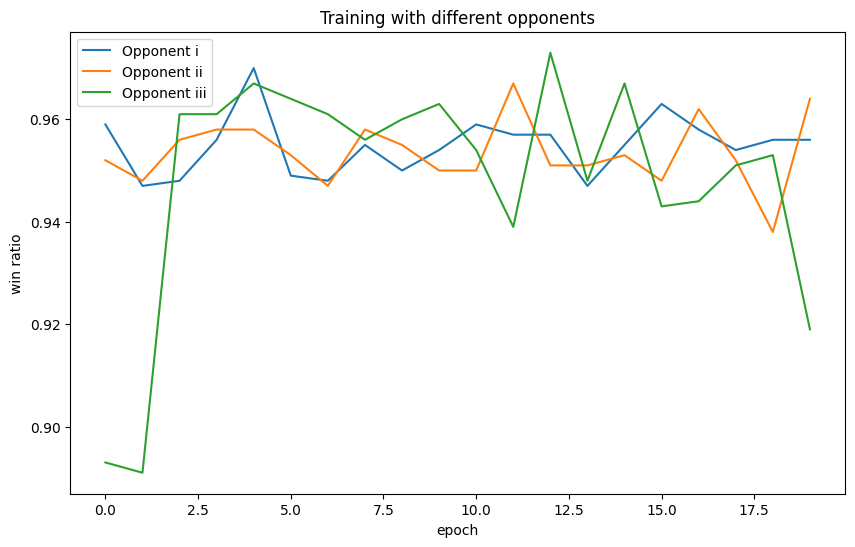

In [6]:
opponents = [
    {"player": Player("O", 0.005, 1.0), "type": "i"},  # opponent i
    {"player": Player_2("O", 0.005, 1.0), "type": "ii"},  # opponent ii
    {"player": Player_3("O", 0.005, 1.0), "type": "iii"}  # opponent iii
]

epoch = 20
epsilon_decay = 0.999
update_epsilon = [0.4]
x = np.arange(epoch)
accuracy = np.zeros(epoch)
plt.figure(figsize=(10, 6))

for opponent in opponents:
    p1 = Player("X", 0.015, 0.4)
    st = Game(p1, opponent["player"])
    for i in tqdm(range(epoch), desc=f'Opponent {opponent["type"]}'):
        for j in range(4000):
            # training
            p1.epsilon = update_epsilon[-1]
            st.play(1, train=True)
            p1.epsilon = max(p1.epsilon * epsilon_decay, 0.2)
        update_epsilon.append(p1.epsilon)
        # testing
        p1.epsilon = 0
        accuracy[i] = st.play(1000, train=False)

    plt.plot(x, accuracy, label=f'Opponent {opponent["type"]}')
    update_epsilon.append(0.4)

plt.xlabel("epoch")
plt.ylabel("win ratio")
plt.title(f'Training with different opponents')
plt.legend()
plt.savefig("result_015.png")
plt.show()

#### 2(e) (Programming)
Use the 10-armed testbed to compare with the greedy and e-greedy method
• A greedy ($\epsilon$ = 0) strategy with an optimistic initial value Q0 = 5.
• An $\epsilon$ = 0.1, 0.01 greedy strategy using upper-confidence-bound (UCB) action selection with c = 2.

With probability $\epsilon$, we will use the UCB formula to select an action.
With probability $1-\epsilon$, we will select the action with the highest estimated value.


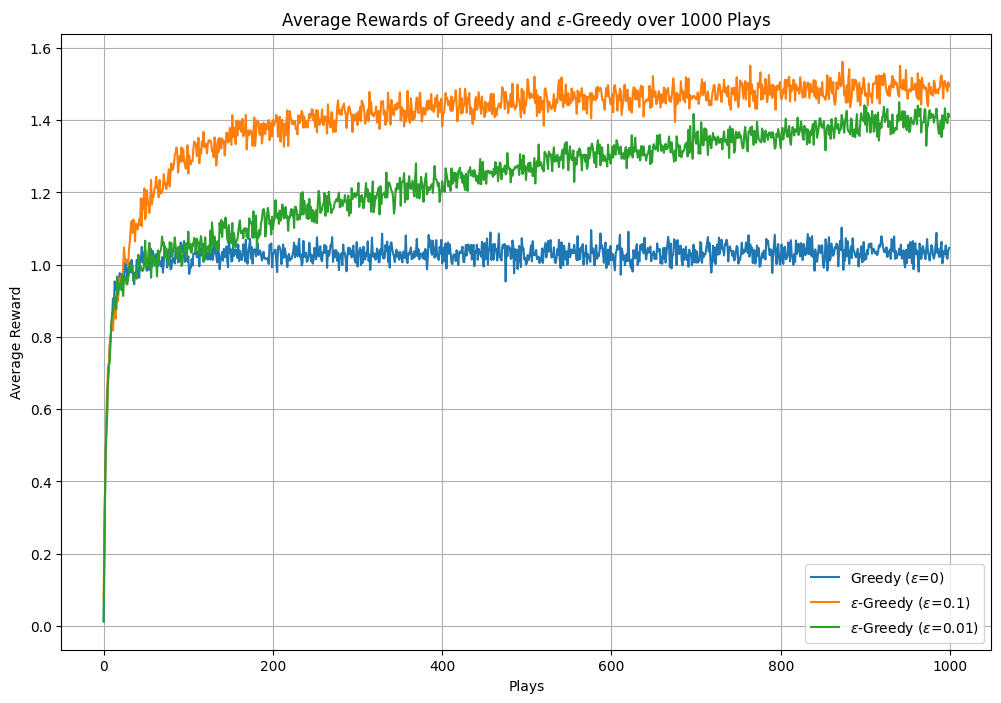

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_bandit_problem_epsilon_ucb(epsilon, n_arms=10, n_steps=1000, n_problems=2000, c=2):
    q_stars = np.random.normal(0, 1, (n_problems, n_arms))
    average_rewards = np.zeros(n_steps)
    for i in range(n_problems):
        Q_estimates = np.zeros(n_arms)
        action_counts = np.zeros(n_arms)
        rewards = np.zeros(n_steps)

        for step in range(n_steps):
            if np.random.rand() <= epsilon:  # use UCB
                confidence_bounds = Q_estimates + c * np.sqrt(np.log(step + 1) / (action_counts + 1e-6))
                action = np.argmax(confidence_bounds)
            else:  
                action = np.argmax(Q_estimates)

            reward = np.random.normal(q_stars[i, action], 1)
            rewards[step] = reward
            action_counts[action] += 1
            Q_estimates[action] += (reward - Q_estimates[action]) / action_counts[action]

        average_rewards += rewards
    # Averaging over tasks
    average_rewards /= n_problems
    return average_rewards

average_rewards_epsilon_0 = simulate_bandit_problem_epsilon_ucb(0)
average_rewards_epsilon_01 = simulate_bandit_problem_epsilon_ucb(0.1)
average_rewards_epsilon_001 = simulate_bandit_problem_epsilon_ucb(0.01)

plt.figure(figsize=(12, 8))
plt.plot(average_rewards_epsilon_0, label="Greedy ($\epsilon$=0)")
plt.plot(average_rewards_epsilon_01, label="$\epsilon$-Greedy ($\epsilon$=0.1)")
plt.plot(average_rewards_epsilon_001, label="$\epsilon$-Greedy ($\epsilon$=0.01)")
plt.xlabel("Plays")
plt.ylabel("Average Reward")
plt.title("Average Rewards of Greedy and $\epsilon$-Greedy over 1000 Plays")
plt.legend()
plt.grid()
plt.show()


#### 2(f) (Programming)
Design and conduct an experiment to demonstrate the difficulties that sample average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q∗(a) start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the q∗(a) on each step). Prepare plots like the ones demonstrated in class for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, α = 0.1. Use e = 0.1 and longer runs, say of 10,000 steps.


/var/folders/pg/j8k7nf9s3gj_r_x7ts9y3p180000gn/T/ipykernel_47528/1418009888.py:37: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rewards_sample[i] = rewards_sample[i] + rewards_sample_temp
/var/folders/pg/j8k7nf9s3gj_r_x7ts9y3p180000gn/T/ipykernel_47528/1418009888.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  rewards_constant[i] = rewards_constant[i] + rewards_constant_temp


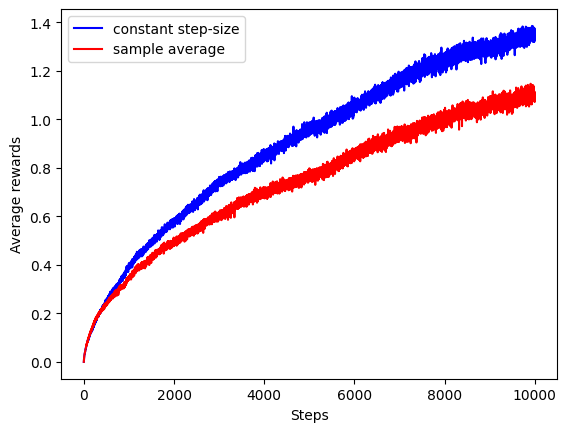

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt

def epsilon_greedy(arms,epsilon,n_arms):
    index_optimized = np.argmax(arms)
    index_all = list(range(0,n_arms))
    if random.random() <= epsilon:
        index_all.remove(index_optimized)
        return random.choices(index_all)
    else:
        return index_optimized

def func(epsilon=0.1,alpha=0.1,n_steps=10000,n_problems=1000,n_arms=10):
    q = np.zeros((n_problems,n_arms))
    Q_constant = np.zeros((n_problems,n_arms))
    Q_sample = np.zeros((n_problems,n_arms))
    N_constant = np.zeros((n_problems,n_arms))
    N_sample = np.zeros((n_problems,n_arms))
    rewards_constant = np.zeros(n_steps)
    rewards_sample = np.zeros(n_steps)

    for i in range(n_steps):
        for j in range(n_problems):
            #nonstationary by normal distributed increment
            q[j,:] = q[j,:] + np.random.normal(0,0.01,n_arms)
            #constant step-size
            index_constant = epsilon_greedy(Q_constant[j,:],epsilon,n_arms)
            rewards_constant_temp = q[j,index_constant]
            rewards_constant[i] = rewards_constant[i] + rewards_constant_temp
            Q_constant[j,index_constant] = Q_constant[j,index_constant] + alpha*(rewards_constant_temp-Q_constant[j,index_constant])
            N_constant[j,index_constant] = N_constant[j,index_constant] + 1

            #sample average
            index_sample = epsilon_greedy(Q_sample[j,:],epsilon,n_arms)
            rewards_sample_temp = q[j,index_sample]
            rewards_sample[i] = rewards_sample[i] + rewards_sample_temp
            N_sample[j,index_sample] = N_sample[j,index_sample] + 1
            if i == 0:
                alpha2 = 1
            else:
                alpha2 = 1/N_sample[j,index_sample]
            Q_sample[j,index_sample] = Q_sample[j,index_sample] + alpha2*(rewards_sample_temp-Q_sample[j,index_sample])

        rewards_constant[i] = rewards_constant[i]/n_problems
        rewards_sample [i] = rewards_sample[i]/n_problems
    return rewards_constant,rewards_sample

average_rewards_constant, average_rewards_sample = func()

plt.plot(average_rewards_constant, 'b', label='constant step-size')
plt.plot(average_rewards_sample, 'r', label='sample average')
plt.xlabel('Steps')
plt.ylabel('Average rewards')
plt.legend(loc='upper left')
plt.show()